# part0: imports

In [54]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator

from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal
import set_rc_params as set_rc

%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']
reload(dt)
reload(set_rc_params)

# Global params
set_rc.set_rc_params()
root = pathlib.Path("/data")

BIN_SIZE = .03  # sec
WINDOW_prep = (-.4, .05)  # sec
WINDOW_exec = (-.05, .40)  # sec
n_components = 10  # min between M1 and PMd
areas = ('M1', 'PMd')
MAX_HISTORY = 3  #int: no of bins to be added as history

prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                     rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                    )
exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                    )
fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_target_on', 
                                         rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                        )

preprocessing

In [2]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

In [3]:
def prep_general (df):
    "preprocessing general!"
    time_signals = [signal for signal in pyal.get_time_varying_fields(df) if 'spikes' in signal]
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    for signal in time_signals:
        df_ = pyal.remove_low_firing_neurons(df, signal, 1)
    
    df_= pyal.select_trials(df, df.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    assert np.all(df_.bin_size == .01), 'bin size is not consistent!'
    df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
    for signal in time_signals:
        df_ = pyal.sqrt_transform_signal(df_, signal)
        
    df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)
    
    
    return df_


%run dataset_selection.ipynb

the variable `GoodDataList` contains the session names


In [6]:
def custom_r2_func(y_true, y_pred):
    "$R^2$ value as squared correlation coefficient, as per Gallego, NN 2020"
    return stats.pearsonr(y_true, y_pred)[0] ** 2

custom_r2_scorer = make_scorer(custom_r2_func)

# Decoding

Decode the arm velocity from M1 activity.

## idea

train the decoder on monkey1 and decode the behaviour of monkey2

>**correction**: the idea is to decode kinematics from the aligned dynamics of 2 monkeys.

### run a test decoder

In [7]:
fname = root / 'Chewie' / "Chewie_CO_CS_2016-10-21.mat"
df = dt.load_pyal_data(fname)
df = prep_general(df)
df_ = pyal.restrict_to_interval(df, epoch_fun=exec_epoch)
model = PCA(10).fit(pyal.concat_trials(df_, 'M1_rates'))
df_ = pyal.apply_dim_reduce_model(df_, model, 'M1_rates', 'M1_pca')

/home/msafaie/REPOS/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [8]:
Y1, Y2 = pyal.concat_trials(df_, 'vel').T

X_no_hist = pyal.concat_trials(df_, 'M1_pca')
print(f'{X_no_hist.shape=}')

X_no_hist.shape=(4290, 10)


In [9]:
X_hist = []
for i in range(4):
    _epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                     rel_start=int(WINDOW_exec[0]/BIN_SIZE)-i,
                                     rel_end=int(WINDOW_exec[1]/BIN_SIZE)-i
                                    )
    _df = pyal.restrict_to_interval(df, epoch_fun=_epoch)
    _model = PCA(n_components).fit(pyal.concat_trials(_df, 'M1_rates'))
    _df = pyal.apply_dim_reduce_model(_df, _model, 'M1_rates', '_pca')
    X_hist.append(pyal.concat_trials(_df, '_pca'))

X = np.concatenate ((*X_hist,), axis=1)

In [10]:
reg = LinearRegression()
reg.fit(X, Y1)
reg.score(X, Y1)

0.8909250016998389

---

**across monkey decoding**

In [11]:
def get_data_array_and_vel(data_list: list[pd.DataFrame], epoch , area: str ='M1', n_components: int =10) -> np.ndarray:
    """
    Applies PCA to the data and return a data matrix of the shape: sessions x targets x  trials x time x PCs
    with the minimum number of trials and timepoints shared across all the datasets/targets.
    
    Parameters
    ----------
    `data_list`: list of pd.dataFrame datasets from pyal-data
    `epoch`: an epoch function of the type `pyal.generate_epoch_fun`
    `area`: area, either: 'M1', or 'S1', or 'PMd'

    Returns
    -------
    `AllData`: np.array

    Signature
    -------
    AllData = get_data_array(data_list, execution_epoch, area='M1', n_components=10)
    all_data = np.reshape(AllData, (-1,10))
    """
    field = f'{area}_rates'
    n_shared_trial = np.inf
    for df in data_list:
        for target in range(8):
            df_ = pyal.select_trials(df, df.target_id== target)
            n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)

    # finding the number of timepoints
    df_ = pyal.restrict_to_interval(df_,epoch_fun=epoch)
    n_timepoints = int(df_[field][0].shape[0])

    # pre-allocating the data matrix
    AllData = np.empty((len(data_list), 8, n_shared_trial, n_timepoints, n_components))
    AllVel  = np.empty((len(data_list), 8, n_shared_trial, n_timepoints, 2))
    rng = np.random.default_rng(12345)
    for session, df in enumerate(data_list):
        df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
        rates = np.concatenate(df_[field].values, axis=0)
        rates -= np.mean(rates, axis=0)
        rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df_, rates_model, field, '_pca');

        for target in range(8):
            df__ = pyal.select_trials(df_, df_.target_id==target)
            all_id = df__.trial_id.to_numpy()
            rng.shuffle(all_id)
            # select the right number of trials to each target
            df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
            for trial, (trial_rates,trial_vel) in enumerate(zip(df__._pca, df__.vel)):
                AllData[session,target,trial, :, :] = trial_rates
                AllVel[session,target,trial, :, :] = trial_vel
    
    return AllData, AllVel

# Within animal decoding

select sessions of the same animal $A$ and $B$ to compute the the canonical axes, and then decode kinematics. One decoder per pair of sessions, similar to the NN paper.

decoder performance cross-validated on the second day in each pair

In [106]:
full_list = []
for area in ('dualArea','M1'):
    for animal, sessionList in GoodDataList[area].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list.append((animal,sessionList))
full_list = [(animal,session) for animal,sessions in full_list for session in set(sessions)]

# load the DFs
warnings.filterwarnings("ignore")
allDFs = []
for animal, session in full_list:
    path = root/animal/session
    allDFs.append(prep_general(dt.load_pyal_data(path)))
warnings.filterwarnings("default")

In [107]:
# pairIndexList = list[ tuple[train1, list[test]]]
pairIndexList = []
for i, (animal1,session1) in enumerate(full_list):
    pairIndexList.append((i,[]))
    for j, (animal2,session2) in enumerate(full_list):
        if animal1 != animal2: continue
        if session1 == session2: continue
        pairIndexList[-1][1].append(j)

cross-validating

**The method below should not be used!! It is just for confirmiation of the next step**

In [108]:
MAX_HISTORY = 3  #int: no of bins

reg_scores = []
for id1, testList in pairIndexList:
    for testId in testList:
        AllData, AllVel = get_data_array_and_vel([allDFs[id1],allDFs[testId]], exec_epoch, area=areas[0], n_components=n_components)
        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel2 = AllVel[1,...]
        # resizing
        AllData1 = AllData1.reshape((-1,n_components))
        AllData2 = AllData2.reshape((-1,n_components))
        min_time = min([AllData1.shape[-2],AllData2.shape[-2]])
        # adding history
        X1_hist = []
        X2_hist = []
        for shift in range(MAX_HISTORY+1):
            X1_hist.append(np.roll(AllData1, shift, axis=0))
            X2_hist.append(np.roll(AllData2, shift, axis=0))
        X1 = np.concatenate((*X1_hist,), axis=1)
        X2 = np.concatenate((*X2_hist,), axis=1)
        # controlling the size
        AllVel2 = AllVel2.reshape((-1,2))[MAX_HISTORY:min_time,:]
        X1 = X1[MAX_HISTORY:min_time,:]  # removing the leading zeros
        X2 = X2[MAX_HISTORY:min_time,:]
    
#         *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        Y_x,Y_y = AllVel2.T
        # train the decoder
        x_score = cross_val_score(LinearRegression(), X2, Y_x, cv=5, scoring = custom_r2_scorer)
        y_score = cross_val_score(LinearRegression(), X2, Y_y, cv= 5, scoring = custom_r2_scorer)
        reg_scores.append((id1,testId,(x_score.mean(),y_score.mean())))

pop_score = []
for _,_,scores in reg_scores:
    pop_score.append(np.add(*scores)/2)
pop_score = np.array(pop_score)

/tmp/ipykernel_6275/279916559.py:39: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
/tmp/ipykernel_6275/279916559.py:39: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
/tmp/ipykernel_6275/279916559.py:39: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
/tmp/ipykernel_6275/279916559.py:39: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
/tmp/ipykernel_6275/2799

118


Text(0.5, 1.0, 'Velocity Decoding')

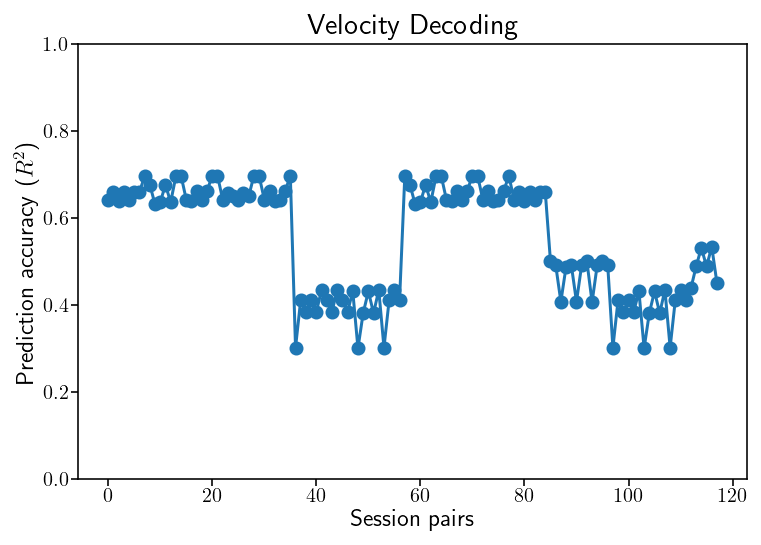

In [109]:
print(pop_score.size)
_,ax = plt.subplots()
ax.plot(pop_score,'-o')
ax.set_ylim([0,1])
ax.set_xlabel('Session pairs')
ax.set_ylabel('Prediction accuracy ($R^2$)')
ax.set_title('Velocity Decoding')

The above results are much lower than the NN paper. But the paper doesn't cross-validate, instead it trains on one day, tests on the other and reports the $R^2$ value

In [110]:
MAX_HISTORY = 3  #int: no of bins

reg_scores = []
for id1, testList in pairIndexList:
    for testId in testList:
        AllData, AllVel = get_data_array_and_vel([allDFs[id1],allDFs[testId]], exec_epoch, area=areas[0], n_components=n_components)
        AllData1 = AllData[0,...]
        AllData2 = AllData[1,...]
        AllVel1 = AllVel[0,...]
        AllVel2 = AllVel[1,...]
        # resizing
        AllData1 = AllData1.reshape((-1,n_components))
        AllData2 = AllData2.reshape((-1,n_components))
        min_time = min([AllData1.shape[-2],AllData2.shape[-2]])
        # adding history
        X1_hist = []
        X2_hist = []
        for shift in range(MAX_HISTORY+1):
            X1_hist.append(np.roll(AllData1, shift, axis=0))
            X2_hist.append(np.roll(AllData2, shift, axis=0))
        X1 = np.concatenate((*X1_hist,), axis=1)
        X2 = np.concatenate((*X2_hist,), axis=1)
        # controlling the size
        AllVel2 = AllVel2.reshape((-1,2))[MAX_HISTORY:min_time,:]
        AllVel1 = AllVel1.reshape((-1,2))[MAX_HISTORY:min_time,:]
        X1 = X1[MAX_HISTORY:min_time,:]  # removing the leading zeros
        X2 = X2[MAX_HISTORY:min_time,:]
    
        *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
        Y_train_x,Y_train_y = AllVel1.T
        # train the decoder
        reg_x = LinearRegression()
        reg_y = LinearRegression()
        reg_x.fit(U, Y_train_x)
        reg_y.fit(U, Y_train_y)
        # test the decoder
        Y_test_x,Y_test_y = AllVel2.T
        x_score = custom_r2_func(Y_test_x,reg_x.predict(V))
        y_score = custom_r2_func(Y_test_y,reg_y.predict(V))
        reg_scores.append((id1,testId,(x_score,y_score)))

pop_score2 = []
for _,_,scores in reg_scores:
    pop_score2.append(np.mean(scores))
pop_score2 = np.array(pop_score2)

118


Text(0.5, 1.0, 'Velocity Decoding')

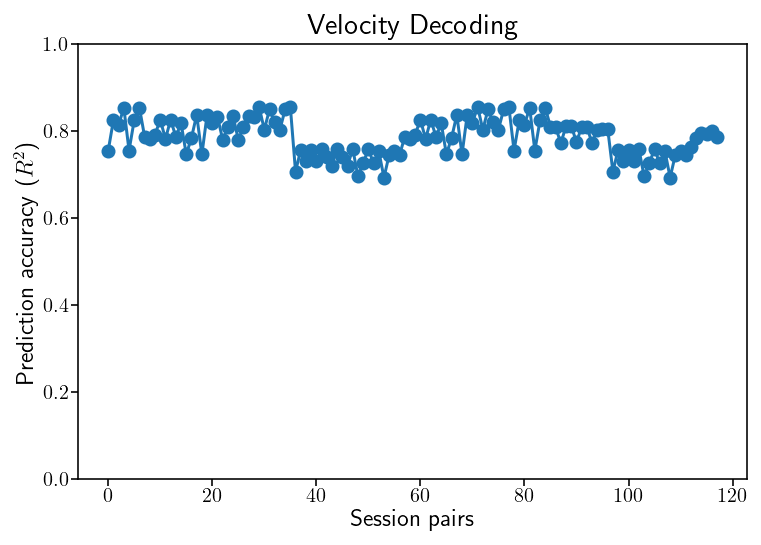

In [111]:
print(pop_score.size)
_,ax = plt.subplots()
ax.plot(pop_score2,'-o')
ax.set_ylim([0,1])
ax.set_xlabel('Session pairs')
ax.set_ylabel('Prediction accuracy ($R^2$)')
ax.set_title('Velocity Decoding')

Now... Same as above, for different animals

# Across animal decoding

In [112]:
full_list = []
for area in ('dualArea','M1'):
    for animal, sessionList in GoodDataList[area].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list.append((animal,sessionList))
full_list = [(animal,session) for animal,sessions in full_list for session in set(sessions)]

# load the DFs
warnings.filterwarnings("ignore")
allDFs = []
for animal, session in full_list:
    path = root/animal/session
    allDFs.append(prep_general(dt.load_pyal_data(path)))
warnings.filterwarnings("default")



pairIndexList = []
for i, (animal1,session1) in enumerate(full_list):
    pairIndexList.append((i,[]))
    for j, (animal2,session2) in enumerate(full_list):
        if animal1 == animal2: continue
        if 'Chewie' in animal1 and 'Chewie' in animal2: continue
        pairIndexList[-1][1].append(j)
pairIndexList = [(i,j) for i,jList in pairIndexList for j in jList]

In [ ]:
reg_scores_across = []
for id1, testId in pairIndexList:
    AllData, AllVel = get_data_array_and_vel([allDFs[id1],allDFs[testId]], exec_epoch, area=areas[0], n_components=n_components)
    AllData1 = AllData[0,...]
    AllData2 = AllData[1,...]
    AllVel1 = AllVel[0,...]
    AllVel2 = AllVel[1,...]
    # resizing
    AllData1 = AllData1.reshape((-1,n_components))
    AllData2 = AllData2.reshape((-1,n_components))
    # adding history
    X1_hist = []
    X2_hist = []
    for shift in range(MAX_HISTORY+1):
        X1_hist.append(np.roll(AllData1, shift, axis=0))
        X2_hist.append(np.roll(AllData2, shift, axis=0))
    X1 = np.concatenate((*X1_hist,), axis=1)
    X2 = np.concatenate((*X2_hist,), axis=1)
    # controlling the size + removing the leading zeros
    AllVel2 = AllVel2.reshape((-1,2))[MAX_HISTORY:,:]
    AllVel1 = AllVel1.reshape((-1,2))[MAX_HISTORY:,:]
    X1 = X1[MAX_HISTORY:,:]
    X2 = X2[MAX_HISTORY:,:]

    # train the decoder
    *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
    Y_train_x,Y_train_y = AllVel1.T
    
    reg_x, reg_y = LinearRegression(), LinearRegression()
    reg_x.fit(U, Y_train_x)
    reg_y.fit(U, Y_train_y)
    # test the decoder
    Y_test_x,Y_test_y = AllVel2.T
    x_score = custom_r2_func(Y_test_x, reg_x.predict(V))
    y_score = custom_r2_func(Y_test_y, reg_y.predict(V))
    reg_scores_across.append((id1,testId,(x_score,y_score)))

pop_score_across = []
for _,_,scores in reg_scores_across:
    pop_score_across.append(np.mean(scores))
pop_score_across = np.array(pop_score_across)

302


Text(0.5, 1.0, 'Velocity Decoding')

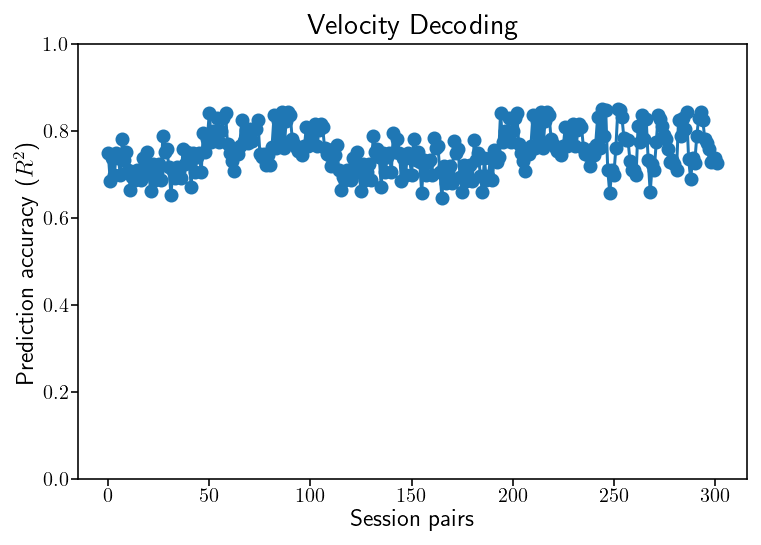

In [114]:
print(pop_score_across.size)

_,ax = plt.subplots()
ax.plot(pop_score_across,'-o')
ax.set_ylim([0,1])
ax.set_xlabel('Session pairs')
ax.set_ylabel('Prediction accuracy ($R^2$)')
ax.set_title('Velocity Decoding')